<a href="https://colab.research.google.com/github/iamstuti/Covid-Detection-on-Chest-X-Ray-Images-using-Pytorch/blob/master/Covid_Detection_using_Resnet_CNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting COVID-19 with Chest X Ray

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [8]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [9]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 738M/745M [00:13<00:00, 51.9MB/s]
100% 745M/745M [00:13<00:00, 57.9MB/s]


In [10]:
!ls

covid19-radiography-database.zip  kaggle.json


In [11]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

# Preparing Training and Test Sets

In [15]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, '/test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [16]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images=[x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] #get the image path for corresponding class
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images={} #dictionary to keep track of images for each class
        self.class_names=['normal','covid','viral']

        
        for c in self.class_names:
            self.images[c]=get_images(c)
            
        self.image_dirs =  image_dirs
        self.transform= transform
        
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
        
    def __getitem__(self,index):
        #to handle class imbalance , instead of directly using the index use index%len(class)
        class_name = random.choice(self.class_names)
        index=index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path=os.path.join(self.image_dirs[class_name], image_name)
            
        #using PIL to open image
        image = Image.open(image_path).convert('RGB')
            
        return self.transform(image),self.class_names.index(class_name)
            
            

# Image Transformations

In [17]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #the horizontal flip does not change class, it can be used to augment data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), #normalized in the same in way that the ImageNet dataset on which Resnet-18 was trained on has, setting the mean and standard deviation as done on different channels on ImageNet
    
])

In [18]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), #normalized in the same in way that the ImageNet dataset on which Resnet-18 was trained on has, setting the mean and standard deviation as done on different channels on ImageNet
    
])

# Prepare DataLoader

In [19]:
train_dirs = {
    'normal': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/normal',
    'viral': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/viral',
    'covid': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/covid'
}

train_dataset= ChestXRayDataset(train_dirs,train_transform)

Found 10162 normal examples
Found 3586 covid examples
Found 1315 viral examples


In [20]:
test_dirs = {
    'normal': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/test/viral',
    'covid': '/content/drive/My Drive/Kaggle/COVID-19_Radiography_Dataset/test/covid'
}

test_dataset= ChestXRayDataset(test_dirs,test_transform)

Found 30 normal examples
Found 30 covid examples
Found 30 viral examples


In [21]:
batch_size=6

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

print("Num of training batches",len(train_dataloader))
print("Num of test batches",len(test_dataloader))

Num of training batches 2511
Num of test batches 15


# Data Visualization

In [22]:
class_names = train_dataset.class_names


def show_images(images,labels,preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1,xticks=[],yticks=[]) # all images in a batch will be shown in one row
        image=image.numpy().transpose((1,2,0)) #converting from  pytorch channel first to channel last
        mean=np.array([0.485,0.458,0.406])
        std= np.array([0.229,0.224,0.225])
        image=image*std+mean #converting image back to what it was before normalization
        image=np.clip(image,0.,1.)
        plt.imshow(image)
        
        col= 'green' if preds[i]==labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color=col)
     
    plt.tight_layout()
    plt.show()
        
        
    

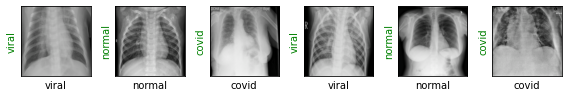

In [23]:
images, labels = next(iter(train_dataloader))
show_images(images,labels,labels)

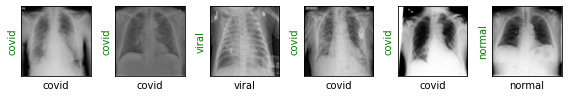

In [24]:
images, labels= next(iter(test_dataloader))
show_images(images,labels,labels)

# Creating the Model

In [25]:
resnet18= torchvision.models.resnet18(pretrained=True)
print(resnet18)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [26]:
#resnet18 was trained on ImageNet dataset which has 1000 classes
#So we need to change the last Fully connected layer to suit to our classes i.e. 3
resnet18.fc=torch.nn.Linear(in_features=512,out_features=3)

loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(),lr=3e-5)



In [27]:
def show_preds():
    resnet18.eval() #to get the predictions
    images,labels= next(iter(test_dataloader))
    outputs= resnet18(images)
    _,preds= torch.max(outputs,1) #indices of maximum val which will be the prediction (dimension=1  is for indices,0 is for number of examples)
    
    show_images(images,labels,preds)

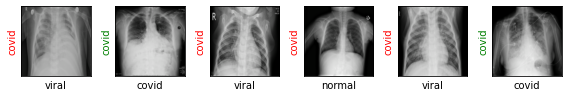

In [28]:
show_preds()

# Training the Model

In [29]:
def train(epochs):
    print('Starting training......')
    
    for e in range(0,epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        
        train_loss = 0
        
        resnet18.train()
        
        
        for step, (images,labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad() #setting all the gradients to zero
            
            outputs = resnet18(images)
            
            loss= loss_fn(outputs,labels)
            
            loss.backward() #take a gradient step based on loss..essentially doing back propagation
            
            optimizer.step() #update all the parameters
            
            train_loss = loss.item()
            
            if step %20 == 0:
                print('Evaluating at step',step)
                
                #calculating validation accuracy...............
                
                acc= 0.
                val_loss =0.
                resnet18.eval() #setting the model in evaluation mode
                
                for val_step, (images,labels) in enumerate(test_dataloader):
                    
                    outputs= resnet18(images)
                    loss = loss_fn(outputs,labels)
                    
                    val_loss += loss.item()
                    
                    _,preds = torch.max(outputs,1)
                    
                    acc += sum((preds==labels).numpy())
                    
                val_loss /= (val_step +1)
                acc = acc/len(test_dataset)
                
                print(f'Val loss: {val_loss:.4f}, Accuracy: {acc:.4f}')
                
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied')
                    return
                
        train_loss /= (step +1)
        print(f'Training loss : {train_loss:.4f}')
        
            

Starting training......
Starting epoch 1/5
Evaluating at step 0
Val loss: 1.3417, Accuracy: 0.3333


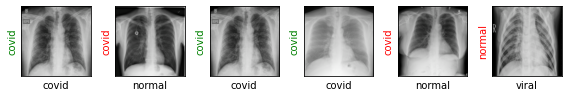

Evaluating at step 20
Val loss: 0.9852, Accuracy: 0.4000


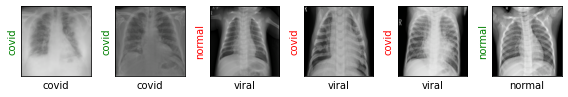

Evaluating at step 40
Val loss: 0.5862, Accuracy: 0.8222


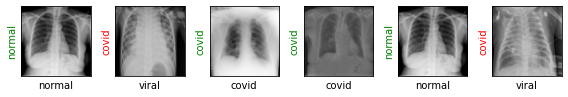

Evaluating at step 60
Val loss: 0.3462, Accuracy: 0.8444


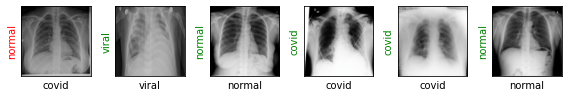

Evaluating at step 80
Val loss: 0.2305, Accuracy: 0.9000


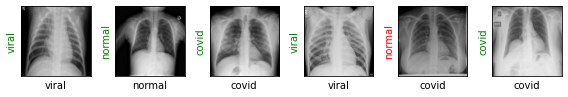

Evaluating at step 100
Val loss: 0.2064, Accuracy: 0.9222


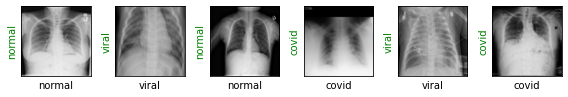

Evaluating at step 120
Val loss: 0.1571, Accuracy: 0.9556


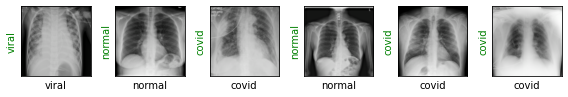

Performance condition satisfied


In [30]:
train(epochs=5)

# Final Results

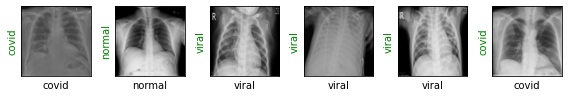

In [31]:
show_preds()

# Training using Resnet34

In [41]:
resnet34= torchvision.models.resnet34(pretrained=True)
print(resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [42]:
resnet34.fc=torch.nn.Linear(in_features=512,out_features=3)

loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet34.parameters(),lr=3e-5)


In [43]:
def show_preds():
    resnet34.eval() #to get the predictions
    images,labels= next(iter(test_dataloader))
    outputs= resnet34(images)
    _,preds= torch.max(outputs,1) #indices of maximum val which will be the prediction (dimension=1  is for indices,0 is for number of examples)
    
    show_images(images,labels,preds)

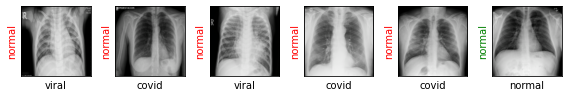

In [44]:
show_preds()

In [47]:
def train(epochs):
    print('Starting training......')
    
    for e in range(0,epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        
        train_loss = 0
        
        resnet34.train()
        
        
        for step, (images,labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad() #setting all the gradients to zero
            
            outputs = resnet34(images)
            
            loss= loss_fn(outputs,labels)
            
            loss.backward() #take a gradient step based on loss..essentially doing back propagation
            
            optimizer.step() #update all the parameters
            
            train_loss = loss.item()
            
            if step %20 == 0:
                print('Evaluating at step',step)
                
                #calculating validation accuracy...............
                
                acc= 0.
                val_loss =0.
                resnet34.eval() #setting the model in evaluation mode
                
                for val_step, (images,labels) in enumerate(test_dataloader):
                    
                    outputs= resnet34(images)
                    loss = loss_fn(outputs,labels)
                    
                    val_loss += loss.item()
                    
                    _,preds = torch.max(outputs,1)
                    
                    acc += sum((preds==labels).numpy())
                    
                val_loss /= (val_step +1)
                acc = acc/len(test_dataset)
                
                print(f'Val loss: {val_loss:.4f}, Accuracy: {acc:.4f}')
                
                show_preds()
                
                resnet34.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied')
                    return
                
        train_loss /= (step +1)
        print(f'Training loss : {train_loss:.4f}')

Starting training......
Starting epoch 1/5
Evaluating at step 0
Val loss: 0.1876, Accuracy: 0.9667


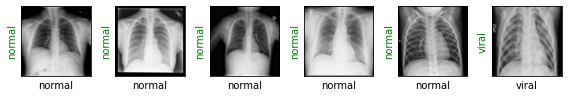

Performance condition satisfied


In [48]:
train(epochs=5)

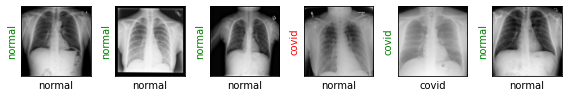

In [49]:
show_preds()